
# Welcome to xxxxxxxxxxx' machine learning interview

If you are here, it's because you made it to the second stage of xxxxxxxxxxxx' interview process. Congratulations!
This is a test so we can better learn about your skills by having you solve a real Machine Learning problem. The outcome is not the most important thing, we want to see your thought process and how you approach the problem, so make sure you write down everything you evaluate to do, approaches that didn't work, etc

# The project

The problem we want to analyze is [this Kaggle competition](https://www.kaggle.com/c/plant-seedlings-classification). Bear in mind you will have 12 hours of GPU to train this notebook.

# What we expect

* An end to end solution, this means you need to be able to understand the description of the problem from the text, download the dataset, train and evaluate the classifier.
* We'll pay special attention to code quality and common pitfalls.
* You need to be able to explain each step and why it is there.
* Explain the data analysis you performed.
* All the code and comments must be in **English**.
* **The notebook must be submitted with all the cells executed**.

# The extra mile

* Carry on a dataset inconsistencies analysis.
* Combine classic computer vision and deep learning techniques.
* Explain what the models are taking into account to generate the predictions.
* In depth error analysis.

# How use this notebook

First, you have to save a copy of this notebook under your own Google Drive account. You can do this by clicking on File > Save a copy in Drive. We have already uploaded the dataset to our Drive so you don't have to. In order to make it accessible from your Colab notebook you first need to add a shortcut of the shared folder we sent you, and then mount your Drive.

# Download the Kaggle's Dataset

Refer to [this guide](https://adityashrm21.github.io/Setting-Up-Kaggle/).

Good luck!

In [3]:
!kaggle competitions download -c plant-seedlings-classification

2023-05-03 14:44:35,335 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f838751b460>, 'Connection to www.kaggle.com timed out. (connect timeout=None)')': /api/v1/competitions/data/download-all/plant-seedlings-classification
2023-05-03 14:46:46,407 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f838751b190>, 'Connection to www.kaggle.com timed out. (connect timeout=None)')': /api/v1/competitions/data/download-all/plant-seedlings-classification
^C
User cancelled operation


In [3]:
#Load some libraries

#The usual ones
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv

# Pytorch related
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import sampler
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, RandomSampler
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization stuff
from PIL import Image
from tqdm import tqdm
import cv2
from sklearn.metrics import confusion_matrix

In [4]:
# Creation of the dataset
class PlantSeedlingsDataset(Dataset):
    def __init__(self, data_dir,img_size=(128,128)):  #Could look like a small shape, but it works very well
        #Define useful self properties
        self.data_dir = data_dir_train
        self.img_size = img_size
        self.transform = transforms.Compose([   # Rotation and flip transformations could be added. The results are good enough without them.
            transforms.Resize(self.img_size),   # Resize transformation to equalize shapes
            transforms.ToTensor()               # PIL to tensor
        ])
        self.classes = os.listdir(data_dir_train)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []
        for cls_name in self.classes:
            cls_dir = os.path.join(data_dir_train, cls_name)
            for file_name in os.listdir(cls_dir):
                image_path = os.path.join(cls_dir, file_name)
                self.images.append(image_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Define the extraction function
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image) # Activate transformations
        image = np.array(image) / 255.0   # Using range [0,1]
        if image.shape[0] == 4:           # There are images with 4 channels
          image = image[:3,:,:]
        image = torch.from_numpy(image).float() # Torch conversion
        return image, label

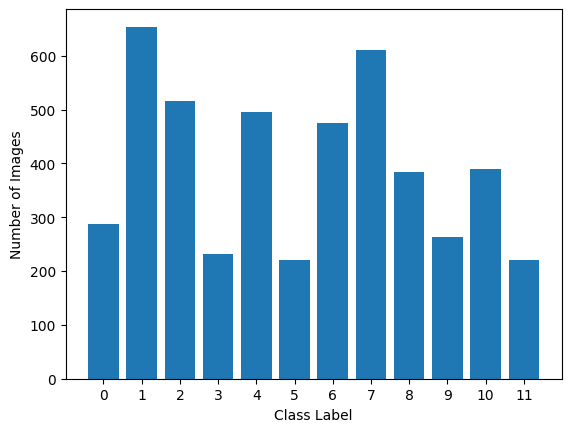

[0.00348432 0.00152905 0.00193798 0.004329   0.00201613 0.00452489
 0.00210526 0.00163666 0.0025974  0.00380228 0.0025641  0.00452489]


In [5]:
# Create an instance of the PlantSeedlingsDataset
dataset = PlantSeedlingsDataset(data_dir=data_dir_train)

# Get the labels from the dataset
labels = dataset.labels

# Count the frequency of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Plot a histogram of the label frequencies
plt.bar(unique_labels, label_counts)
plt.xticks(unique_labels)
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.show()

# Calculate the weights for the weighted sampler
class_counts = np.bincount(dataset.labels)
class_weights = 1.0 / class_counts

print(class_weights)

In [6]:


# Create a list of weights for each data point
weights = np.array([class_weights[label] for label in dataset.labels])

# Split the dataset into training and validation sets
train_size = 0.8
train_count = int(len(dataset) * train_size)
val_count = len(dataset) - train_count
train_dataset, valid_dataset = random_split(
    dataset,[train_count, val_count])

# Calculate the correct weight distribution
y_train_indices = train_dataset.indices
y_train = [dataset.labels[i] for i in y_train_indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
weighted_sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=weighted_sampler)
val_loader = DataLoader(valid_dataset, batch_size=64, sampler=sampler.RandomSampler(valid_dataset))

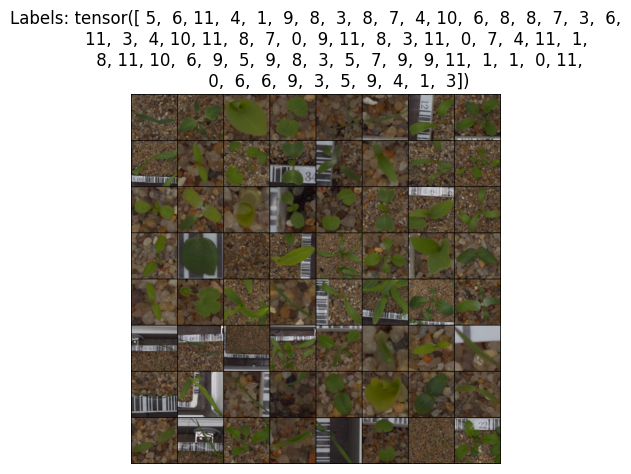

In [7]:
# Visualize some examples
data, label = next(iter(train_loader))
img = vutils.make_grid(data, padding=2, normalize=True)
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title(f"Labels: {label}")
plt.axis('off')
plt.show()

In [8]:

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
lr = 0.001                                #<------- The lr can be fine-tuned in succesive trainings, but I rather use a lr scheduler
num_epochs = 20

# Define model
model = resnet18(pretrained=True)         #<------- Multiple networks could have been considered and found the best one. However, it gave very good results on the first try with resnet18
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


In [9]:

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Some variables
data_model_dir = '/content/drive/My Drive/Tryolabs_int/'      #<------ Where I saved the model and the sample submission
patience = 10
best_acc=0

# Full training procedure
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0.0
    # Train step (loss + backprop + step)
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader)
    print(f"Train loss: {train_loss:.4f}")
    
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    # Validation step (calculation of accuracy)
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    valid_loss /= len(val_loader)
    accuracy = correct / total
    print(f"Validation loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    # Adjust the learning rate based on the validation accuracy
    scheduler.step(accuracy)
    
    # Save the model if the validation accuracy improves
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save(model.state_dict(), data_model_dir + "best_model.pt")
        print("Model saved!")
    
    # Early stopping if the validation accuracy doesn't improve for a certain number of epochs
    if epoch > patience and accuracy <= best_acc:
        print(f"No improvement in validation accuracy for {patience} epochs. Early stopping...")
        break

Epoch 1/20


100%|██████████| 60/60 [12:11<00:00, 12.19s/it]


Train loss: 52.4648


100%|██████████| 15/15 [04:55<00:00, 19.70s/it]


Validation loss: 429.8326, Accuracy: 0.0516
Model saved!
Epoch 2/20


100%|██████████| 60/60 [05:07<00:00,  5.13s/it]


Train loss: 23.5449


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Validation loss: 141.1893, Accuracy: 0.4547
Model saved!
Epoch 3/20


100%|██████████| 60/60 [02:37<00:00,  2.63s/it]


Train loss: 16.7274


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Validation loss: 34.8324, Accuracy: 0.8242
Model saved!
Epoch 4/20


100%|██████████| 60/60 [01:50<00:00,  1.83s/it]


Train loss: 14.3219


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Validation loss: 40.0628, Accuracy: 0.8074
Epoch 5/20


100%|██████████| 60/60 [01:17<00:00,  1.30s/it]


Train loss: 12.5974


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Validation loss: 34.0591, Accuracy: 0.8389
Model saved!
Epoch 6/20


100%|██████████| 60/60 [01:12<00:00,  1.21s/it]


Train loss: 7.5894


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Validation loss: 51.2253, Accuracy: 0.7737
Epoch 7/20


100%|██████████| 60/60 [01:03<00:00,  1.07s/it]


Train loss: 9.1711


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Validation loss: 56.7415, Accuracy: 0.7695
Epoch 8/20


100%|██████████| 60/60 [01:03<00:00,  1.05s/it]


Train loss: 8.6803


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Validation loss: 61.0450, Accuracy: 0.7516
Epoch 9/20


100%|██████████| 60/60 [00:59<00:00,  1.00it/s]


Train loss: 5.6093


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Validation loss: 28.6838, Accuracy: 0.8821
Model saved!
Epoch 10/20


100%|██████████| 60/60 [01:00<00:00,  1.00s/it]


Train loss: 4.5166


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Validation loss: 20.6659, Accuracy: 0.8958
Model saved!
Epoch 11/20


100%|██████████| 60/60 [01:00<00:00,  1.01s/it]


Train loss: 2.5202


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Validation loss: 21.5787, Accuracy: 0.8947
Epoch 12/20


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


Train loss: 3.6991


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]

Validation loss: 30.3130, Accuracy: 0.8716
No improvement in validation accuracy for 10 epochs. Early stopping...


In [10]:
# Load the saved model parameters
data_model_dir = '/content/drive/My Drive/Tryolabs_int/' #<------(this is also here to not run the above cell again)

model.load_state_dict(torch.load(data_model_dir + 'best_model.pt'))

# Put the model in evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Here I got a bit confused at the beginning. I thought I had to use the "sample_submission" to check the labels of the test set.
# After realizing it was only an example, I kept the code because the first column of the .csv has all the names of the files in order and it was easy to work with
# (That's why the list it's named "dir_beets", as all the labels in "sample_submission" are "Sugar Beets")


data_dir_root = '/content/drive/My Drive/Tryolabs-CV-Interview/data/'
lista_columna = []

with open(data_dir_root + 'sample_submission.csv', newline='') as archivo_csv:
    lector_csv = csv.reader(archivo_csv, delimiter=',')
    for fila in lector_csv:
        lista_columna.append(fila[0])

lista_columna = lista_columna[1:]
print(lista_columna)

data_dir_test = '/content/drive/My Drive/Tryolabs-CV-Interview/data/test/'
def buscar_archivo(nombre_archivo, directorio):
    for archivo in os.listdir(directorio):
        if archivo == nombre_archivo:
            return os.path.join(directorio, archivo)
    return None

dir_beets = []
for j in np.arange( len(lista_columna)):
  ruta_archivo = buscar_archivo(lista_columna[j], data_dir_test)
  if ruta_archivo is not None:
      dir_beets.append(ruta_archivo)
  else:
      print("El archivo no se encontró en el directorio especificado.")

['0021e90e4.png', '003d61042.png', '007b3da8b.png', '0086a6340.png', '00c47e980.png', '00d090cde.png', '00ef713a8.png', '01291174f.png', '026716f9b.png', '02cfeb38d.png', '03566743d.png', '03a2ee656.png', '03e322a29.png', '03ef36742.png', '043449b0b.png', '0437393b1.png', '04814f36d.png', '05341a8a6.png', '060450d79.png', '060f1dc84.png', '0625f063b.png', '063363305.png', '06d12f6fa.png', '071cb3ece.png', '0751c0bbc.png', '07e62f903.png', '085974290.png', '0885e7690.png', '089ad62a7.png', '08d591441.png', '0911d3dee.png', '099b961ec.png', '0a64e3e6c.png', '0ad9e7dfb.png', '0ae6668fa.png', '0bf7bfb05.png', '0c27cf05f.png', '0c4199daa.png', '0c45ace27.png', '0c51bf229.png', '0c5f6c493.png', '0caeda5df.png', '0d117d910.png', '0d31e6602.png', '0dba99002.png', '0e8492cb1.png', '0ebf8f2f4.png', '0ee4ad224.png', '0f6cbe5e8.png', '0fb233ad6.png', '115f93ecc.png', '116b136de.png', '1191ba346.png', '11d3f68ff.png', '122913909.png', '12625488b.png', '126a71ce0.png', '1312065a5.png', '1364b297a.pn

In [12]:
plant_classes = ['Cleavers', 'Loose Silky-bent', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Common wheat', 'Fat Hen', 'Common Chickweed', 'Sugar beet', 'Black-grass', 'Charlock, Maize']

plant_id=[]
plant_class=[]

# Load the image and convert it to a PyTorch tensor and do the transforms

for j in np.arange(len(dir_beets)):
  image = Image.open(dir_beets[j])
  transform = transforms.Compose([
      transforms.Resize((128,128)),
      transforms.ToTensor()])
  image = transform(image)
  image = np.array(image) / 255.0 
  if image.shape[0] == 4:           #Hay imágenes con 4 canales. Los reduzco a 3
    image = image[:3,:,:]
  image = torch.from_numpy(image).float() 
  
  # Load the PyTorch model and run the tensor through it
  model.eval()
  image = image.cuda()
  output = model(torch.unsqueeze(image,0))

  plant_id.append(dir_beets[j][len(dir_beets[0])-13:])
  plant_class.append(plant_classes[1-int(output.argmax())])

In [13]:
# Save the submission
with open(data_model_dir + 'sample_sub.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['file', 'species'])
    for i in range(len(plant_id)):
        writer.writerow([plant_id[i], plant_class[i]])

#Error analysis

100%|██████████| 15/15 [00:13<00:00,  1.12it/s]

[[ 56   1   1   0   0   0   0   0   0   0   0   0]
 [  0 116   3   0   0   0   0   0   0  15   0   0]
 [  0   0 112   1   0   0   0   1   0   0   0   0]
 [  0   0   4  40   0   0   0   0   0   0   0   0]
 [  3   1   1   0 103   0   0   0   0   0   0   0]
 [  0   4   0   0   0  29   0   0   1   6   0   0]
 [  2   2   0   0   2   0  84   0   1   0   1   0]
 [  0   0   1   2   4   0   0 109   1   0   0   0]
 [  1   0   3   0   1   2   0   0  64   0   1   1]
 [  0  16   0   0   0   1   0   0   0  32   0   0]
 [  0   0   6   0   1   0   1   0   0   0  63   0]
 [  0   0   1   0   0   1   2   0   3   0   0  43]]


<function matplotlib.pyplot.show(close=None, block=None)>

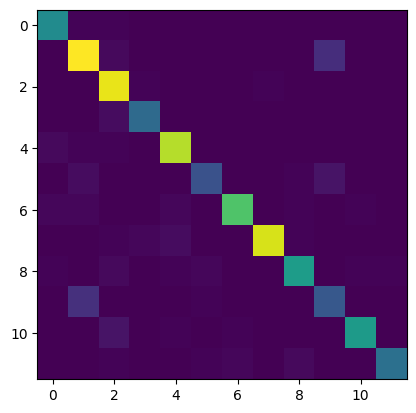

In [14]:
# Function to build the predictions and labels. I could've saved them before, saving some time, but didn't think of it at the moment
def build_ys():
  y_pred = []
  y_true=[]
  with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        y_pred = y_pred +  list(outputs.argmax(axis=1).cpu())
        y_true = y_true + list(labels.cpu())
  return y_pred, y_true
  
#list of true labels and list of predicted labels
y_pred, y_true = build_ys()

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# show confusion matrix
print(cm)

plt.imshow(cm)
plt.show

El clasificador parece estar andando bien a excepción de confundir un poco la entrada 1 con la 9, y la entrada 9 con la 1. Estos son "Loose Silky-bent" y "Black-grass". A continuación veamos por qué:

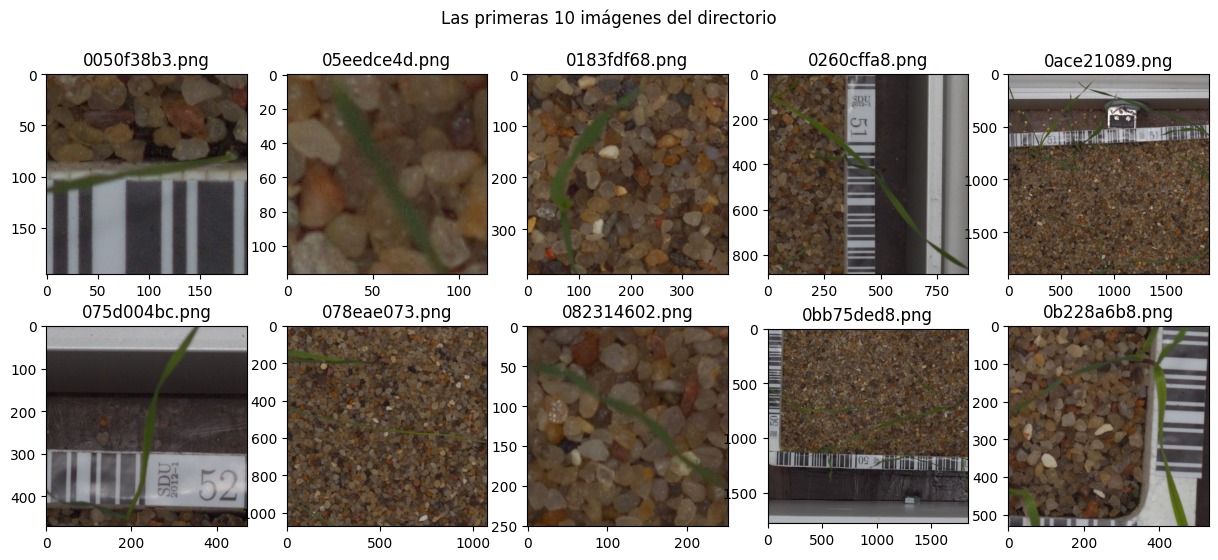

In [15]:
# ruta del directorio que se desea recorrer
directorio = data_dir_train + '/Black-grass/'

# List of files in directory
file_list = os.listdir(directorio)

# Filter only images
img_list = [f for f in file_list if f.endswith('.jpg') or f.endswith('.png')]

# Take the first 10 images just as an example
img_list = img_list[:10]

# Config the subplot
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Las primeras 10 imágenes del directorio')

# Add the images to subplot
for i, img_path in enumerate(img_list):
    img = matplotlib.image.imread(os.path.join(directorio, img_path))
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(img_path)

# Show subplot
plt.show()

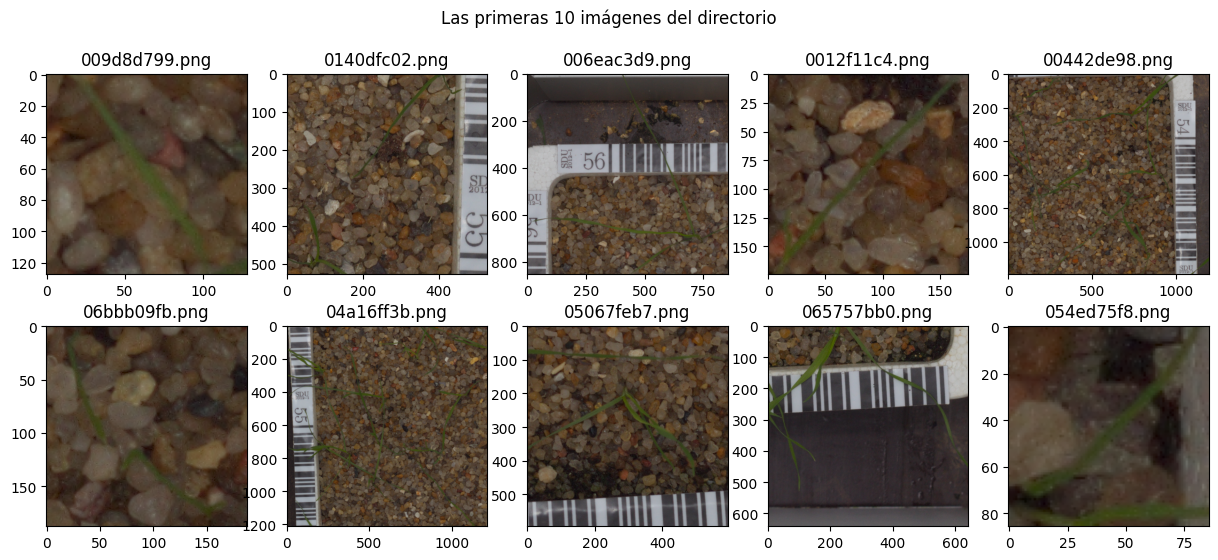

In [16]:

# ruta del directorio que se desea recorrer
directorio = data_dir_train + '/Loose Silky-bent/'

# Lista de archivos en el directorio
file_list = os.listdir(directorio)

# Filtrar solo los archivos de imagen
img_list = [f for f in file_list if f.endswith('.jpg') or f.endswith('.png')]

# Tomar solo los primeros 10 archivos de imagen
img_list = img_list[:10]

# Configurar el subplot
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Las primeras 10 imágenes del directorio')

# Recorrer las imágenes y agregarlas al subplot
for i, img_path in enumerate(img_list):
    img = matplotlib.image.imread(os.path.join(directorio, img_path))
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(img_path)

# Mostrar el subplot
plt.show()

Claramente, ambos son muy similares. El ojo humano ciertamente las confundiría, pero aún así el algoritmo hace un trabajo bastante bueno, clasificando correctamente la mayoría (dependiendo del batch entre 3 y 20 errores c/u).

# Mapas de saliencia

Para ver qué están observando la red, calculamos los mapas de saliencia paso a paso.

In [17]:
# Set the model to evaluation mode in cas it wasn't
model.eval()

# Lista de archivos en el directorio
directorio = data_dir_test
file_list = os.listdir(directorio)

# Load the input image using OpenCV
img_list = [f for f in file_list if f.endswith('.jpg') or f.endswith('.png')]
img_list = img_list[:20]

for image, img_path in enumerate(img_list):
  image = matplotlib.image.imread(os.path.join(directorio, img_path))

  # Convert the image to a PyTorch tensor
  transform = transforms.ToTensor()

  # Apply the transformations to the image
  tensor = transform(image)

  # Set requires_grad attribute of tensor
  tensor.requires_grad = True

  # Display the original image
  plt.figure(figsize=(4, 4))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title('Original Image', fontsize=16)

  # Forward pass through the model
  output = model(tensor.unsqueeze(0).cuda())
  output = output[:,output.argmax()]

  # Calculate the gradients of the output with respect to the input
  output.backward()

  # Get the gradients of the input image
  gradients = tensor.grad.abs().squeeze().numpy()

  # Normalize the gradients
  gradients /= gradients.max()

  # Create a saliency map by taking the maximum value across the color channels
  saliency_map = gradients.max(axis=0)

  # Resize the saliency map to match the original image size
  saliency_map = cv2.resize(saliency_map, image.shape[:2][::-1])
  #saliency_map = cv2.cvtColor(saliency_map, cv2.COLOR_BGR2RGB)

  # Convert the data type to a larger one
  max_val = np.max([np.max(saliency_map), np.max(image)])
  dtype = np.uint8 if max_val <= 255 else np.uint16
  img1 = saliency_map.astype(dtype)
  img2 = image.astype(dtype)

  # Load the RGB and grayscale images
  rgb_image = image
  grayscale_image = saliency_map

  # Resize the grayscale image to match the dimensions of the RGB image
  grayscale_image_resized = cv2.resize(grayscale_image, (rgb_image.shape[1], rgb_image.shape[0]))

  # Convert the grayscale image to a 3-channel image
  grayscale_image_3ch = np.stack((grayscale_image_resized,) * 3, axis=-1)
  plt.figure(figsize=(4, 4))
  plt.imshow(grayscale_image_3ch[:,:,0])
  plt.show()
  


Output hidden; open in https://colab.research.google.com to view.

Como puede verse, en la mayoría de los casos se observan las regiones relevantes